REFERENCE: https://github.com/TropComplique/lda2vec-pytorch/blob/master/20newsgroups/get_windows.ipynb

In [142]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [143]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
from tqdm import tqdm
import spacy
from gensim import corpora, models
import pandas as pd
import sys
sys.path.append('..')
from utils import preprocess, get_windows
from nltk.tokenize.treebank import TreebankWordDetokenizer

In [144]:
MIN_COUNTS = 20
MAX_COUNTS = 1800
# words with count < MIN_COUNTS
# and count > MAX_COUNTS
# will be removed

MIN_LENGTH = 15
# minimum document length 
# (number of words)
# after preprocessing

# half the size of the context around a word
HALF_WINDOW_SIZE = 5
# it must be that 2*HALF_WINDOW_SIZE < MIN_LENGTH

In [4]:
nlp = spacy.load('en')

In [66]:
#dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
#docs = dataset['data']
#docs

dataset = pd.read_csv('Documents_Complete.csv')
docs = []
df_docs = dataset[dataset['body'].notnull()]
for row_val in df_docs['body']:
    val = str(row_val).split(',')
    docs.append(''.join(val))
    
len(docs)

17966

In [69]:
# number of documents
len(docs)

17966

In [150]:
encoded_docs, decoder, word_counts = preprocess(
    docs, nlp, MIN_LENGTH, MIN_COUNTS, MAX_COUNTS
)



100%|██████████| 17966/17966 [03:08<00:00, 95.43it/s] 


number of removed short documents: 2831
total number of tokens: 1032380
number of tokens to be removed: 387389
number of additionally removed short documents: 2727
total number of tokens: 616937

minimum word count number: 14
this number can be less than MIN_COUNTS because of document removal


In [152]:
#print("encoded_docs ", len(encoded_docs[6][1])) # Token ids per document
print("decoder ",decoder[0])
#print("word_counts ", word_counts)

decoder  produc


In [153]:
# new ids will be created for the documents.
# create a way of restoring initial ids:
doc_decoder = {i: doc_id for i, (doc_id, doc) in enumerate(encoded_docs)}
#print(doc_decoder)

In [74]:
data = []
# new ids are created here
for index, (_, doc) in tqdm(enumerate(encoded_docs)):
    windows = get_windows(doc, HALF_WINDOW_SIZE)
    # index represents id of a document, 
    # windows is a list of (word, window around this word),
    # where word is in the document
    #print("--------------------------------")
    #print(windows)
    data += [[index, w[0]] + w[1] for w in windows]
    #print(data)

data = np.array(data, dtype='int64')
#print("final data")
print(data[0])

12408it [00:01, 8629.92it/s]


[   0  214  791 1314  238  434  212  656  142 1314 1140 2607]


In [75]:
# a row in 'data' contains:
# id of a document, id of a word in this document, a window around this word
# 1 + 1 + 10
data.shape[1]

12

In [76]:
# number of windows (equals to the total number of tokens)
data.shape[0]

616937

In [77]:
word_counts = np.array(word_counts)
unigram_distribution = word_counts/sum(word_counts)
unigram_distribution.shape

(3361,)

In [78]:
#%%time
vocab_size = len(decoder)
embedding_dim = 50

# train a skip-gram word2vec model
texts = [[str(j) for j in doc] for i, doc in encoded_docs]
model = models.Word2Vec(texts, size=embedding_dim, window=5, workers=4, sg=1, negative=15, iter=70)
model.init_sims(replace=True)

word_vectors = np.zeros((vocab_size, embedding_dim)).astype('float32')
for i in decoder:
    word_vectors[i] = model.wv[str(i)]

In [79]:
# number of unique words
vocab_size

3361

In [80]:
texts = [[decoder[j] for j in doc] for i, doc in encoded_docs]
#print(texts[0])
dictionary = corpora.Dictionary(texts)
#print(dictionary)
corpus = [dictionary.doc2bow(text) for text in texts]

print(corpus[2])
print(len(corpus))

[(9, 1), (12, 1), (66, 1), (67, 2), (68, 1), (69, 1), (70, 1), (71, 1), (72, 1), (73, 1), (74, 3), (75, 1), (76, 2), (77, 1), (78, 1), (79, 1), (80, 1), (81, 1), (82, 1), (83, 1), (84, 2), (85, 3), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 2), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 7), (102, 3), (103, 1), (104, 1)]
12408


In [81]:
decoder[0]

'produc'

In [82]:
#%%time
n_topics = 20
lda = models.LdaModel(corpus, alpha=0.9, id2word=dictionary, num_topics=n_topics)
corpus_lda = lda[corpus]

In [83]:
print(corpus_lda[100])

[(0, 0.029970279), (1, 0.027664118), (2, 0.029886022), (3, 0.026627326), (4, 0.026710885), (5, 0.02792833), (6, 0.027052961), (7, 0.032401383), (8, 0.03107119), (9, 0.028256265), (10, 0.03155321), (11, 0.026502926), (12, 0.06564446), (13, 0.030501861), (14, 0.08083056), (15, 0.039353523), (16, 0.2226098), (17, 0.036009595), (18, 0.06579383), (19, 0.113631465)]


In [84]:
for i, topics in lda.show_topics(n_topics, formatted=False):
    print('topic', i, ':', ' '.join([t for t, _ in topics]))

topic 0 : telecommun telephon cabl wireless electr commiss water northeast power announc
topic 1 : franc french kuwaiti court union approv network claim broadcast strike
topic 2 : investor debentur insur moodi rais underwrit coupon asset save convert
topic 3 : brazil negoti creditor payment talk philippin commerci line american debtor
topic 4 : comput gold softwar technolog person introduc ounc avail machin line
topic 5 : tender ship strike merger right dilut ministri acquir outstand receiv
topic 6 : west currenc baker polici germani economi german accord louvr japanes
topic 7 : wheat agricultur grain soviet crop farm soybean corn depart china
topic 8 : file offic sharehold chief sugar director suit commiss approv chairman
topic 9 : copper canadian cent produc european beef gatt negoti open commun
topic 10 : contract motor plant option ford worker union interst local chicago
topic 11 : iran attack iranian gulf militari forc tehran iraq destroy ship
topic 12 : produc credit buffer cocoa

In [85]:
doc_weights_init = np.zeros((len(corpus_lda), n_topics))
for i in tqdm(range(len(corpus_lda))):
    topics = corpus_lda[i]
    for j, prob in topics:
        doc_weights_init[i, j] = prob

100%|██████████| 12408/12408 [00:03<00:00, 3176.64it/s]


In [86]:
doc_weights_init.shape[0]

12408

**Save the Results**

In [87]:
np.save('data.npy', data)
np.save('word_vectors.npy', word_vectors)
np.save('unigram_distribution.npy', unigram_distribution)
np.save('decoder.npy', decoder)
np.save('doc_decoder.npy', doc_decoder)
np.save('doc_weights_init.npy', doc_weights_init)

**Data Visualization**

**Graphs REFERENCE - https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/**

**Word Clouds of Top N Keywords in Each Topic**

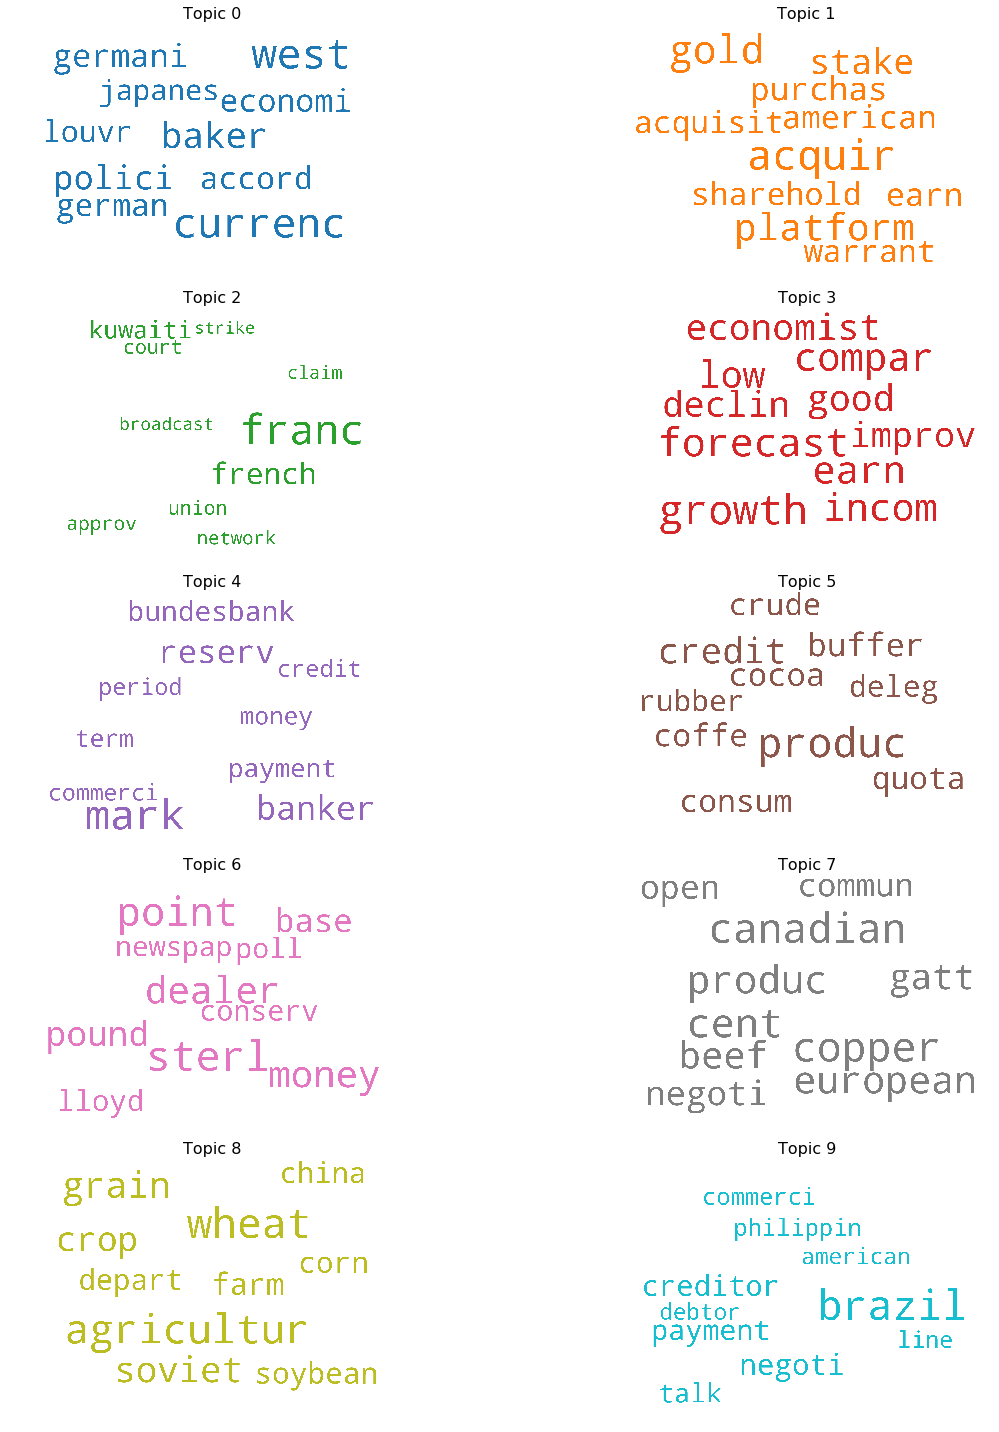

In [88]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(20,20), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

In [89]:
def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()
    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

df_topic_sents_keywords = format_topics_sentences(ldamodel=lda, corpus=corpus, texts=docs)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
doc_lens = [len(d) for d in df_dominant_topic.Text]
df_dominant_topic.head()

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,15.0,0.2253,"growth, forecast, compar, earn, incom, low, go...",said expect earlier report remov jone industri...
1,1,0.0,0.2872,"telecommun, telephon, cabl, wireless, electr, ...",mason former presid chief oper offic empir car...
2,2,18.0,0.5873,"drug, test, approv, bill, research, blood, eff...",discoveri complic search vaccin team armi doct...
3,3,18.0,0.6793,"drug, test, approv, bill, research, blood, eff...",doctor center diseas control atlanta said evid...
4,4,15.0,0.5277,"growth, forecast, compar, earn, incom, low, go...",econom data week determin interest rate futur ...


In [99]:
len(df_dominant_topic)

17966

**Frequency Distribution of Word Counts in Documents**

To know the size of documents

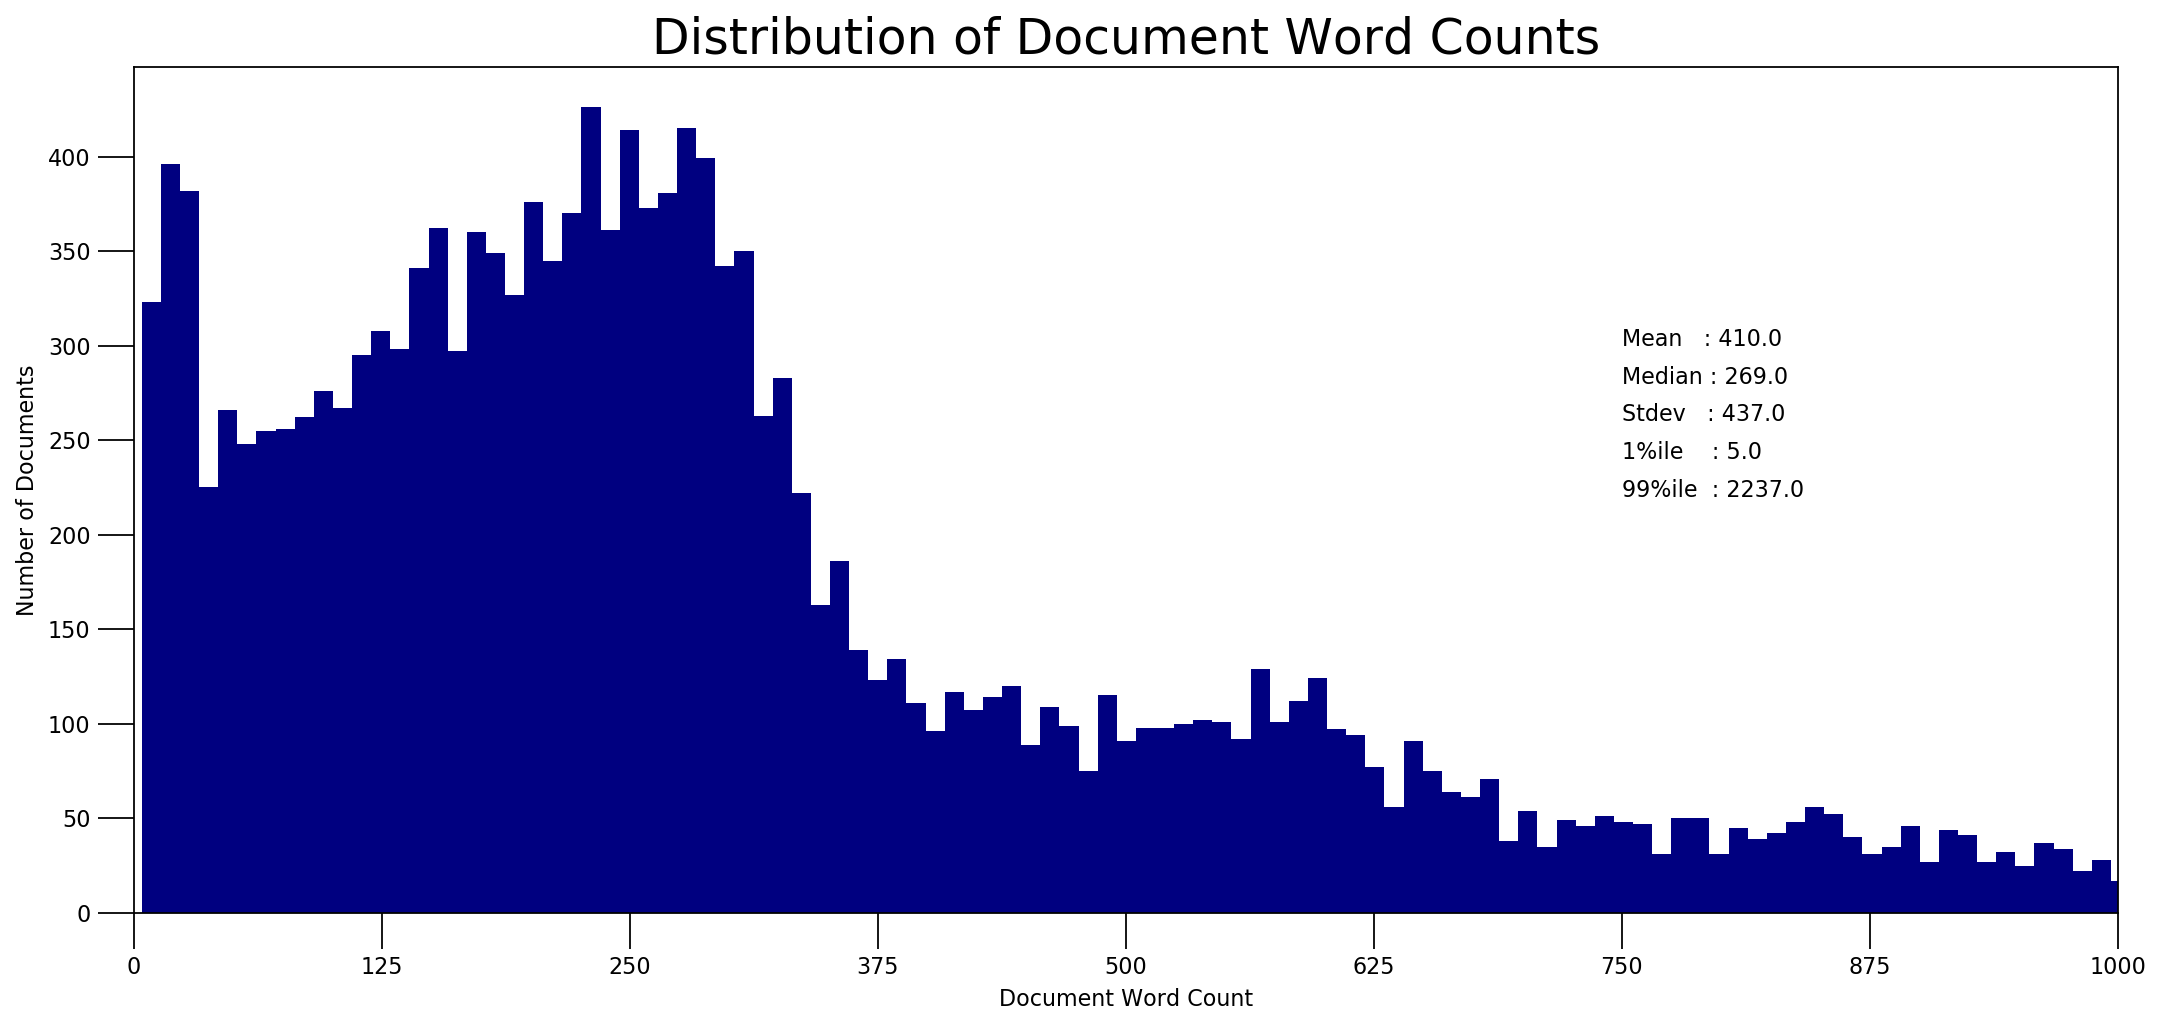

In [97]:
# Plot
plt.figure(figsize=(16,7), dpi=160)
plt.hist(doc_lens, bins = 500, color='navy')
plt.text(750, 300, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(750, 280, "Median : " + str(round(np.median(doc_lens))))
plt.text(750, 260, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(750, 240, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(750, 220, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 500), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,1000,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

**Distribution of Document Word Counts by Dominant Topic**

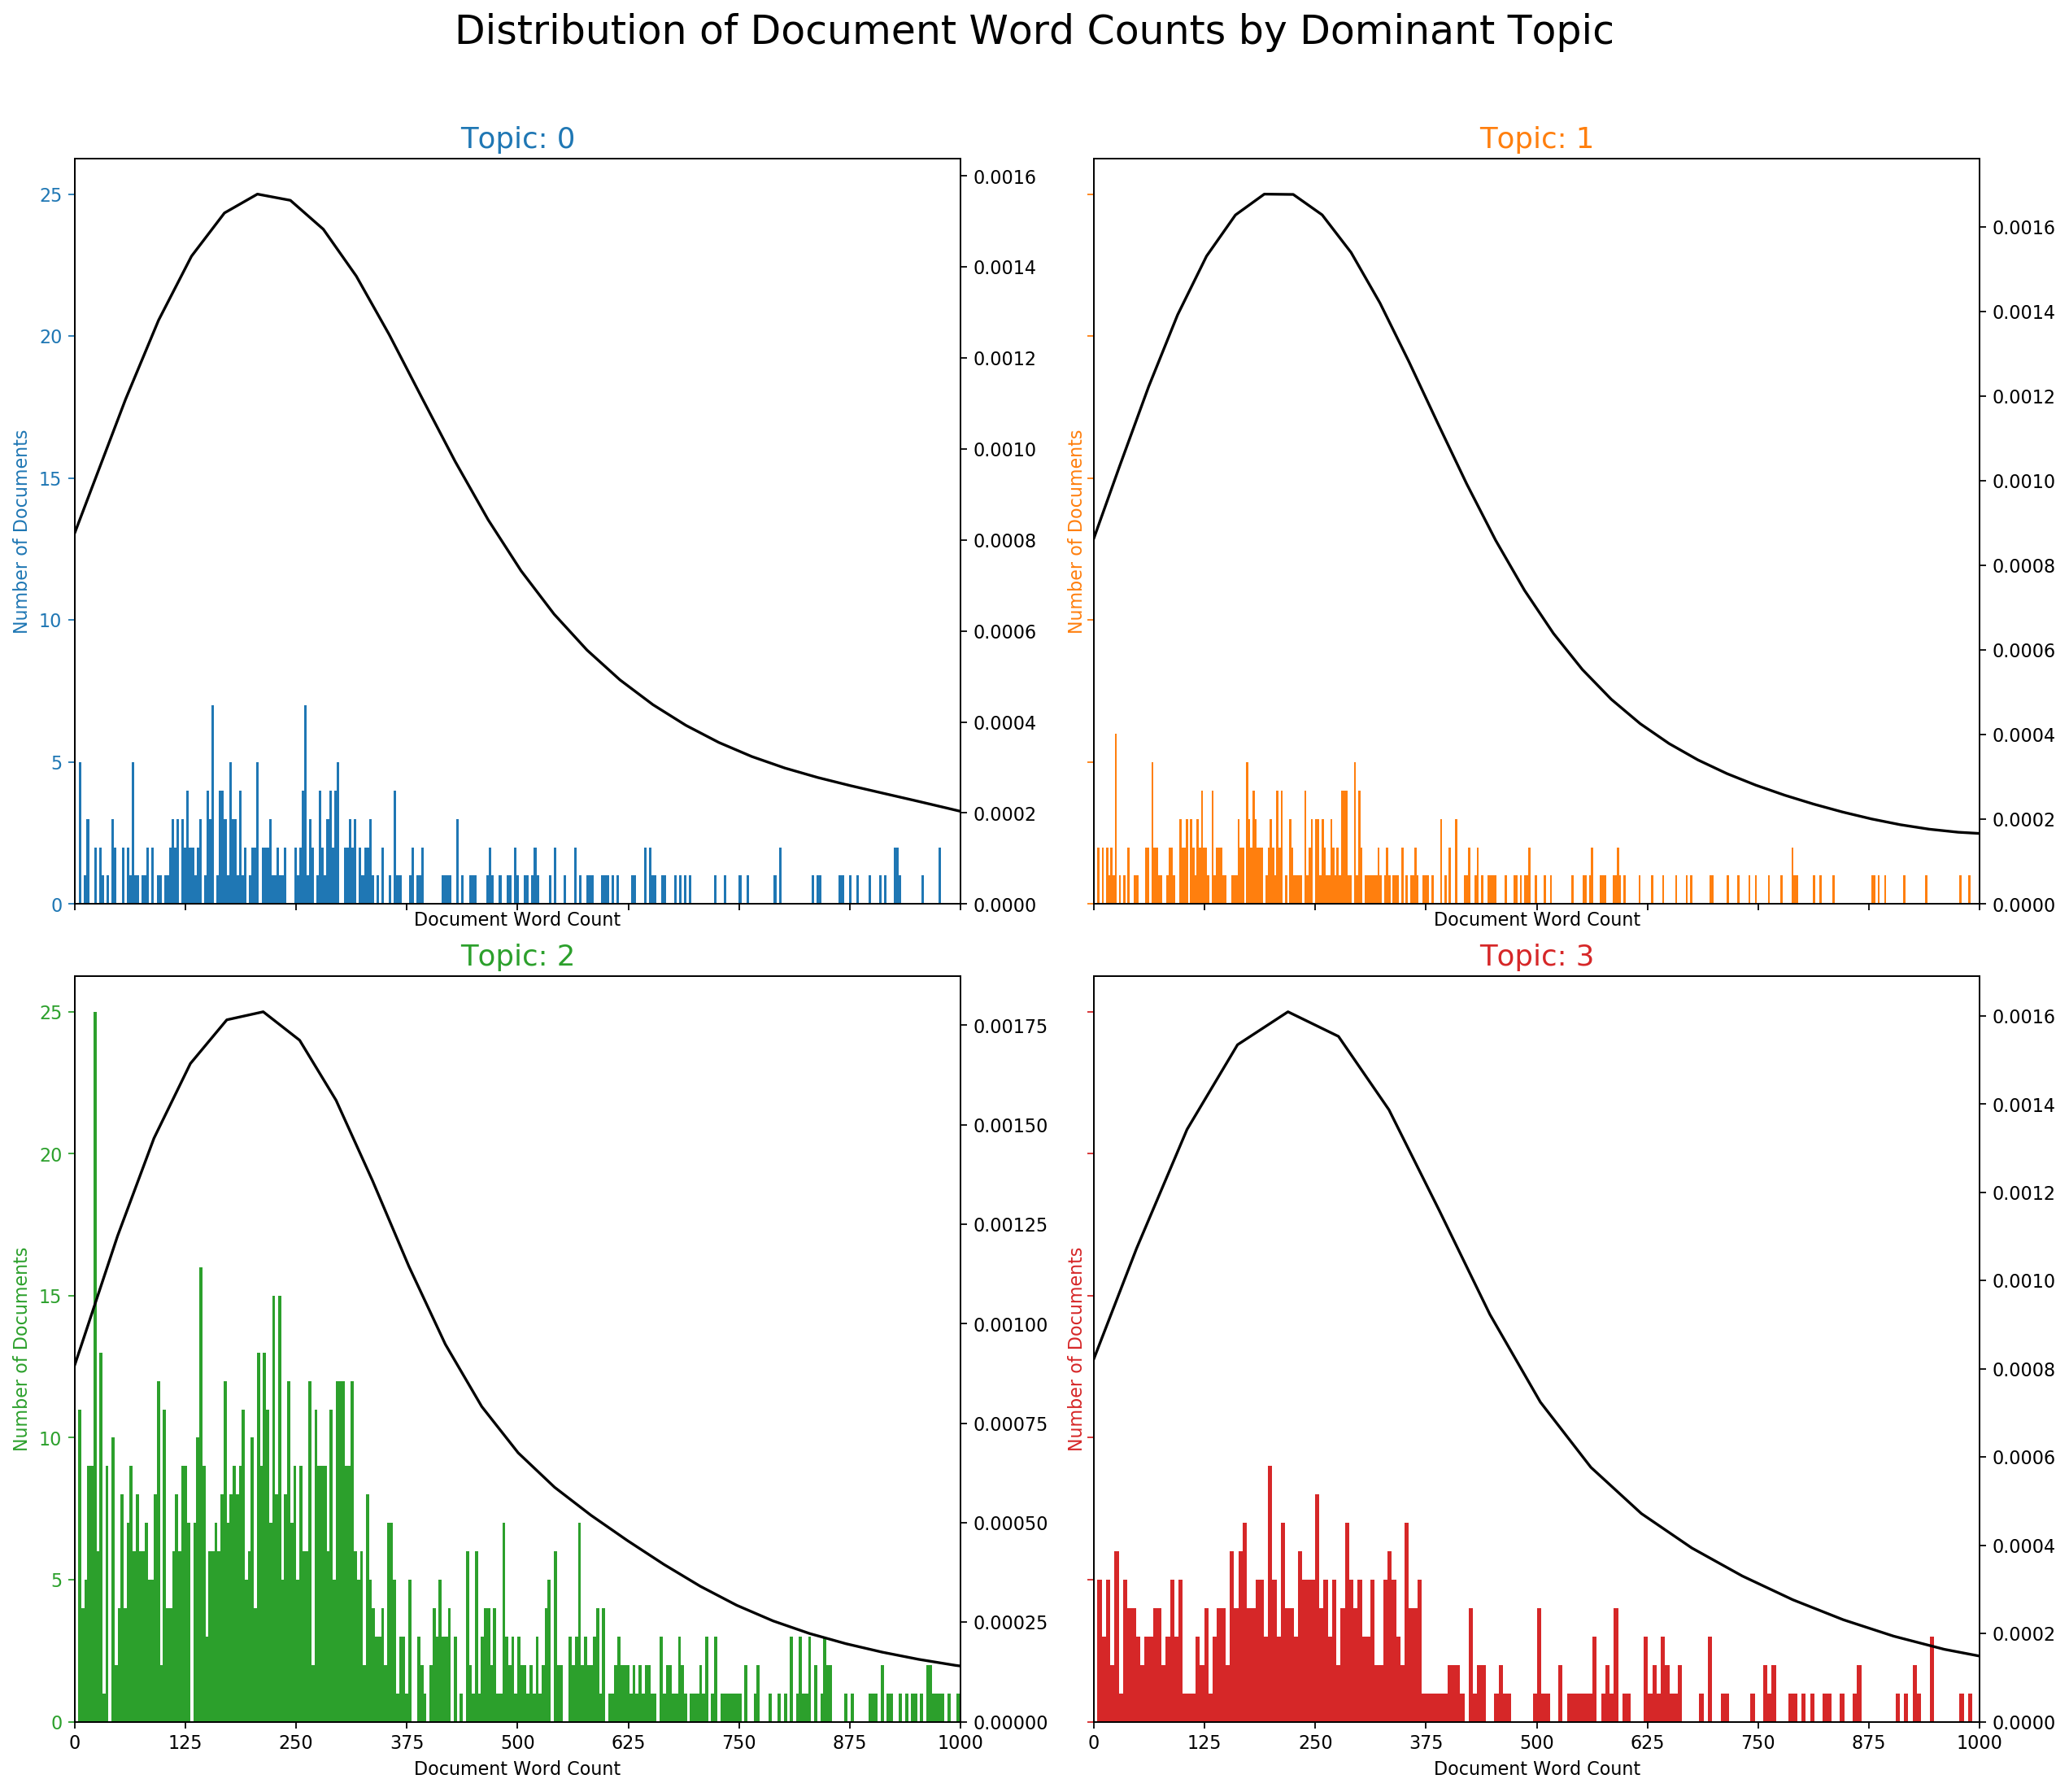

In [98]:
import seaborn as sns
import matplotlib.colors as mcolors
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

fig, axes = plt.subplots(2,2,figsize=(16,14), dpi=160, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):    
    df_dominant_topic_sub = df_dominant_topic.loc[df_dominant_topic.Dominant_Topic == i, :]
    doc_lens = [len(d) for d in df_dominant_topic_sub.Text]
    ax.hist(doc_lens, bins = 1000, color=cols[i])
    ax.tick_params(axis='y', labelcolor=cols[i], color=cols[i])
    sns.kdeplot(doc_lens, color="black", shade=False, ax=ax.twinx())
    ax.set(xlim=(0, 1000), xlabel='Document Word Count')
    ax.set_ylabel('Number of Documents', color=cols[i])
    ax.set_title('Topic: '+str(i), fontdict=dict(size=16, color=cols[i]))

fig.tight_layout()
fig.subplots_adjust(top=0.90)
plt.xticks(np.linspace(0,1000,9))
fig.suptitle('Distribution of Document Word Counts by Dominant Topic', fontsize=22)
plt.show()

**Word Counts of Topic Keywords**

In [146]:
"""from collections import Counter
topics = lda.show_topics(formatted=False)
data_flat = [w for w_list in docs for w in w_list]
counter = Counter(data_flat)

out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight, counter[word]])

df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
    #ax_twin = ax.twinx()
    #ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
    ax.set_ylabel('Word Count', color=cols[i])
    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0, 3500)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    #ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

fig.tight_layout(w_pad=2)    
fig.suptitle('Word Count and Importance of Topic Keywords', fontsize=22, y=1.05)    
plt.show()"""

'from collections import Counter\ntopics = lda.show_topics(formatted=False)\ndata_flat = [w for w_list in docs for w in w_list]\ncounter = Counter(data_flat)\n\nout = []\nfor i, topic in topics:\n    for word, weight in topic:\n        out.append([word, i , weight, counter[word]])\n\ndf = pd.DataFrame(out, columns=[\'word\', \'topic_id\', \'importance\', \'word_count\'])        \n\n# Plot Word Count and Weights of Topic Keywords\nfig, axes = plt.subplots(2, 2, figsize=(16,10), sharey=True, dpi=160)\ncols = [color for name, color in mcolors.TABLEAU_COLORS.items()]\nfor i, ax in enumerate(axes.flatten()):\n    ax.bar(x=\'word\', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label=\'Word Count\')\n    #ax_twin = ax.twinx()\n    #ax_twin.bar(x=\'word\', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label=\'Weights\')\n    ax.set_ylabel(\'Word Count\', color=cols[i])\n    #ax_twin.set_ylim(0, 0.030); ax.set_ylim(0,

**Sentence Chart Colored by Topic**

In [147]:
"""
# Sentence Coloring of N Sentences
from matplotlib.patches import Rectangle

def sentences_chart(lda_model=lda, corpus=corpus, start = 0, end = 13):
    corp = corpus[start:end]
    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]

    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       
    axes[0].axis('off')
    for i, ax in enumerate(axes):
        if i > 0:
            corp_cur = corp[i-1] 
            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur][0:3]
            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    
            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment='center',
                    fontsize=16, color='black', transform=ax.transAxes, fontweight=700)

            # Draw Rectange
            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)
            ax.add_patch(Rectangle((0.0, 0.05), 0.99, 0.90, fill=None, alpha=1, 
                                   color=mycolors[topic_percs_sorted[0][0]], linewidth=2))

            word_pos = 0.06
            for j, (word, topics) in enumerate(word_dominanttopic):
                if j < 14:
                    ax.text(word_pos, 0.5, word,
                            horizontalalignment='left',
                            verticalalignment='center',
                            fontsize=16, color=mycolors[topics],
                            transform=ax.transAxes, fontweight=700)
                    word_pos += .009 * len(word)  # to move the word for the next iter
                    ax.axis('off')
            ax.text(word_pos, 0.5, '. . .',
                    horizontalalignment='left',
                    verticalalignment='center',
                    fontsize=16, color='black',
                    transform=ax.transAxes)       

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.suptitle('Sentence Topic Coloring for Documents: ' + str(start) + ' to ' + str(end-2), fontsize=22, y=0.95, fontweight=700)
    plt.tight_layout()
    plt.show()

sentences_chart() """

'\n# Sentence Coloring of N Sentences\nfrom matplotlib.patches import Rectangle\n\ndef sentences_chart(lda_model=lda, corpus=corpus, start = 0, end = 13):\n    corp = corpus[start:end]\n    mycolors = [color for name, color in mcolors.TABLEAU_COLORS.items()]\n\n    fig, axes = plt.subplots(end-start, 1, figsize=(20, (end-start)*0.95), dpi=160)       \n    axes[0].axis(\'off\')\n    for i, ax in enumerate(axes):\n        if i > 0:\n            corp_cur = corp[i-1] \n            topic_percs, wordid_topics, wordid_phivalues = lda_model[corp_cur][0:3]\n            word_dominanttopic = [(lda_model.id2word[wd], topic[0]) for wd, topic in wordid_topics]    \n            ax.text(0.01, 0.5, "Doc " + str(i-1) + ": ", verticalalignment=\'center\',\n                    fontsize=16, color=\'black\', transform=ax.transAxes, fontweight=700)\n\n            # Draw Rectange\n            topic_percs_sorted = sorted(topic_percs, key=lambda x: (x[1]), reverse=True)\n            ax.add_patch(Rectangle((0.0,

**What are the most discussed topics in the documents?**

In [148]:
"""
def topics_per_document(model, corpus, start=0, end=1):
    corpus_sel = corpus[start:end]
    #print("corp ",corpus_sel)
    dominant_topics = []
    topic_percentages = []
    for i, corp in enumerate(corpus_sel):
        #print(model[corp])
        #topic_percs, wordid_topics = model[corp]
        topic_percs = model[corp]
        #print("topic percs = ",topic_percs)
        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]
        dominant_topics.append((i, dominant_topic))
        topic_percentages.append(topic_percs)
    #print(dominant_topics)
    #print(topic_percentages)
    return(dominant_topics, topic_percentages)

dominant_topics, topic_percentages = topics_per_document(model=lda, corpus=corpus, end=-1)            

# Distribution of Dominant Topics in Each Document
df = pd.DataFrame(dominant_topics, columns=['Document_Id', 'Dominant_Topic'])
dominant_topic_in_each_doc = df.groupby('Dominant_Topic').size()
df_dominant_topic_in_each_doc = dominant_topic_in_each_doc.to_frame(name='count').reset_index()

# Total Topic Distribution by actual weight
topic_weightage_by_doc = pd.DataFrame([dict(t) for t in topic_percentages])
df_topic_weightage_by_doc = topic_weightage_by_doc.sum().to_frame(name='count').reset_index()

# Top 3 Keywords for each Topic
topic_top3words = [(i, topic) for i, topics in lda.show_topics(formatted=False) 
                                 for j, (topic, wt) in enumerate(topics) if j < 3]

df_top3words_stacked = pd.DataFrame(topic_top3words, columns=['topic_id', 'words'])
df_top3words = df_top3words_stacked.groupby('topic_id').agg(', \n'.join)
df_top3words.reset_index(level=0,inplace=True)"""

'\ndef topics_per_document(model, corpus, start=0, end=1):\n    corpus_sel = corpus[start:end]\n    #print("corp ",corpus_sel)\n    dominant_topics = []\n    topic_percentages = []\n    for i, corp in enumerate(corpus_sel):\n        #print(model[corp])\n        #topic_percs, wordid_topics = model[corp]\n        topic_percs = model[corp]\n        #print("topic percs = ",topic_percs)\n        dominant_topic = sorted(topic_percs, key = lambda x: x[1], reverse=True)[0][0]\n        dominant_topics.append((i, dominant_topic))\n        topic_percentages.append(topic_percs)\n    #print(dominant_topics)\n    #print(topic_percentages)\n    return(dominant_topics, topic_percentages)\n\ndominant_topics, topic_percentages = topics_per_document(model=lda, corpus=corpus, end=-1)            \n\n# Distribution of Dominant Topics in Each Document\ndf = pd.DataFrame(dominant_topics, columns=[\'Document_Id\', \'Dominant_Topic\'])\ndominant_topic_in_each_doc = df.groupby(\'Dominant_Topic\').size()\ndf_domi

In [149]:
"""from matplotlib.ticker import FuncFormatter

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)

# Topic Distribution by Dominant Topics
ax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')
ax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))
tick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])
ax1.xaxis.set_major_formatter(tick_formatter)
ax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))
ax1.set_ylabel('Number of Documents')
ax1.set_ylim(0, 1000)"""

"from matplotlib.ticker import FuncFormatter\n\n# Plot\nfig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=120, sharey=True)\n\n# Topic Distribution by Dominant Topics\nax1.bar(x='Dominant_Topic', height='count', data=df_dominant_topic_in_each_doc, width=.5, color='firebrick')\nax1.set_xticks(range(df_dominant_topic_in_each_doc.Dominant_Topic.unique().__len__()))\ntick_formatter = FuncFormatter(lambda x, pos: 'Topic ' + str(x)+ '\n' + df_top3words.loc[df_top3words.topic_id==x, 'words'].values[0])\nax1.xaxis.set_major_formatter(tick_formatter)\nax1.set_title('Number of Documents by Dominant Topic', fontdict=dict(size=10))\nax1.set_ylabel('Number of Documents')\nax1.set_ylim(0, 1000)"

**t-SNE Clustering Chart**

In [151]:
"""# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(lda[corpus]):
    #print(row_list[0][1])
    topic_weights.append(row_list[0][1])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 4
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)"""

'# Get topic weights and dominant topics ------------\nfrom sklearn.manifold import TSNE\nfrom bokeh.plotting import figure, output_file, show\nfrom bokeh.models import Label\nfrom bokeh.io import output_notebook\n\n# Get topic weights\ntopic_weights = []\nfor i, row_list in enumerate(lda[corpus]):\n    #print(row_list[0][1])\n    topic_weights.append(row_list[0][1])\n\n# Array of topic weights    \narr = pd.DataFrame(topic_weights).fillna(0).values\n\n# Keep the well separated points (optional)\narr = arr[np.amax(arr, axis=1) > 0.35]\n\n# Dominant topic number in each doc\ntopic_num = np.argmax(arr, axis=1)\n\n# tSNE Dimension Reduction\ntsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init=\'pca\')\ntsne_lda = tsne_model.fit_transform(arr)\n\n# Plot the Topic Clusters using Bokeh\noutput_notebook()\nn_topics = 4\nmycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])\nplot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topic

**pyLDAviz**

In [119]:
import pyLDAvis.gensim
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda, corpus, dictionary=lda.id2word)
vis

/Users/snehachoudhary/anaconda3/lib/python3.7/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
6     -0.165755  0.041983       1        1  9.537378
15    -0.101692 -0.068145       2        1  8.586117
17    -0.105685  0.029217       3        1  7.081653
7     -0.034271 -0.156273       4        1  6.057054
3     -0.066728  0.052303       5        1  5.745952
13     0.114215 -0.013881       6        1  5.268247
19    -0.024559  0.042550       7        1  5.110672
8      0.061652  0.023582       8        1  5.082736
12    -0.019597 -0.047696       9        1  4.941629
2      0.048952  0.034287      10        1  4.936524
10     0.040150 -0.017669      11        1  4.717097
4      0.091257 -0.042979      12        1  4.032345
5      0.079019  0.023332      13        1  3.880478
16    -0.021849  0.014203      14        1  3.768777
0      0.040904 -0.001157      15        1  3.728847
1      0.027890  0.053151      16        1  3.686607
18     0.008057  0.013821      17        1  3.616209
9     -0.015303 -0.029910      18        1  3.601296
14     0.024124 -0.007824      19        1  3.418555
11     0.019218  0.057107      20        1  3.201830, topic_info=     Category         Freq        Term        Total  loglift  logprob
686   Default  1291.000000       franc  1291.000000  30.0000  30.0000
1018  Default   904.000000      comput   904.000000  29.0000  29.0000
585   Default  1162.000000      brazil  1162.000000  28.0000  28.0000
1154  Default   997.000000       wheat   997.000000  27.0000  27.0000
148   Default  1589.000000    contract  1589.000000  26.0000  26.0000
429   Default   863.000000        iran   863.000000  25.0000  25.0000
745   Default   622.000000     iranian   622.000000  24.0000  24.0000
736   Default   731.000000      attack   731.000000  23.0000  23.0000
1368  Default  1206.000000        mark  1206.000000  22.0000  22.0000
672   Default  1220.000000  agricultur  1220.000000  21.0000  21.0000
1147  Default   782.000000       grain   782.000000  20.0000  20.0000
1160  Default   786.000000        gold   786.000000  19.0000  19.0000
217   Default  1156.000000      budget  1156.000000  18.0000  18.0000
2232  Default   459.000000        drug   459.000000  17.0000  17.0000
897   Default   759.000000        crop   759.000000  16.0000  16.0000
705   Default   969.000000      soviet   969.000000  15.0000  15.0000
182   Default  1065.000000       order  1065.000000  14.0000  14.0000
1918  Default   615.000000    platform   615.000000  13.0000  13.0000
1465  Default   940.000000        gulf   940.000000  12.0000  12.0000
2906  Default   504.000000       louvr   504.000000  11.0000  11.0000
949   Default   644.000000       motor   644.000000  10.0000  10.0000
546   Default   937.000000      tender   937.000000   9.0000   9.0000
21    Default  1607.000000      produc  1607.000000   8.0000   8.0000
618   Default  1400.000000     deficit  1400.000000   7.0000   7.0000
1359  Default   492.000000     soybean   492.000000   6.0000   6.0000
832   Default   856.000000      banker   856.000000   5.0000   5.0000
1609  Default   509.000000        corn   509.000000   4.0000   4.0000
687   Default   661.000000      french   661.000000   3.0000   3.0000
1674  Default   376.000000      buffer   376.000000   2.0000   2.0000
310   Default  1178.000000       baker  1178.000000   1.0000   1.0000
...       ...          ...         ...          ...      ...      ...
2933  Topic20    14.610923    conjunct    26.933620   2.8298  -7.2093
3260  Topic20    20.227278      tribun    38.885368   2.7879  -6.8840
67    Topic20    51.227238        armi   100.068802   2.7719  -5.9548
82    Topic20   185.818710    militari   371.364716   2.7490  -4.6663
758   Topic20     6.413343       wound    12.960831   2.7379  -8.0327
1712  Topic20    41.155716      border    87.958572   2.6819  -6.1737
2220  Topic20    95.153496       radio   222.103729   2.5938  -5.3356
1465  Topic20   296.416962        gulf   940.958496   2.2863 